In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
import os

In [21]:
# load the data Airbnb_Open_Data.csv into a pandas DataFrame and display the first 5 rows
cwd = os.getcwd()
if os.path.basename(cwd) == "Notebooks":
    project_root = os.path.dirname(cwd)
else:
    project_root = cwd
data_path = os.path.join(project_root, "data", "Airbnb_Open_Data.csv")
df = pd.read_csv(data_path)

/var/folders/l4/cvtt5nrn021dbz6fwy92xdh00000gn/T/ipykernel_26927/1341269372.py:8: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [24]:
# romoveing license features as it contains only NaN values (only 2 non-null values)
df = df.drop(columns=['license'])

In [25]:
# The dataset is largely complete across features, with missing values primarily in 
# ['last_review', 'reviews_per_month', and 'house_rules']
# Removing all rows containing NaN values reduces the dataset from 102599 to 39627 observations.
# If this loss is too large, we could consider imputing 'reviews_per_month' and 'last_review'.
df = df.dropna().reset_index(drop=True)

In [26]:
# convert 'last_review' to datetime format
df['last review'] = pd.to_datetime(df['last review'])
# float cast and remove $ for [price, serivice_fee]
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['service fee'] = df['service fee'].replace('[\$,]', '', regex=True).astype(float)

In [27]:
df['host id'].nunique()

39415

In [28]:
# Check for listings outside NYC 
nyc_lat_min, nyc_lat_max = 40.4774, 40.9176
nyc_lon_min, nyc_lon_max = -74.2591, -73.7004
out_of_bounds_count = df[
    (~df["lat"].between(nyc_lat_min, nyc_lat_max)) |
    (~df["long"].between(nyc_lon_min, nyc_lon_max))
].shape[0]

print(f"{out_of_bounds_count} listings are located outside the NYC bounding box.")


0 listings are located outside the NYC bounding box.


In [29]:
# plot of Airbnb listings in NYC (5000 random samples)
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=11, tiles='cartodbpositron')
for _, row in df.sample(5000, random_state=1).iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["long"]],
        radius=1,
        color="red",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)
m

In [30]:
# look for dubplicate listings based on 'host id', 'host name', 'lat', and 'long'
duplicates = df.duplicated(subset=['host id', 'host name', 'lat', 'long'])
print(f"There are {duplicates.sum()} duplicate listings based on host id, host name, lat, and long")
# remove duplicates
df = df.drop_duplicates(subset=['host id', 'host name', 'lat', 'long']).reset_index(drop=True)

There are 212 duplicate listings based on host id, host name, lat, and long


In [31]:
# remove obserations with 'minimum nights' outside 1, 100 range
# This needed to be done, as there were some extreme outliers (-100 and 1000+ nights)
df = df[df['minimum nights'].between(1, 100)].reset_index(drop=True)

In [32]:
# nomralize neighborhood group and neighborhood to lowercase
df['neighbourhood group'] = df['neighbourhood group'].str.lower()
df['neighbourhood'] = df['neighbourhood'].str.lower()

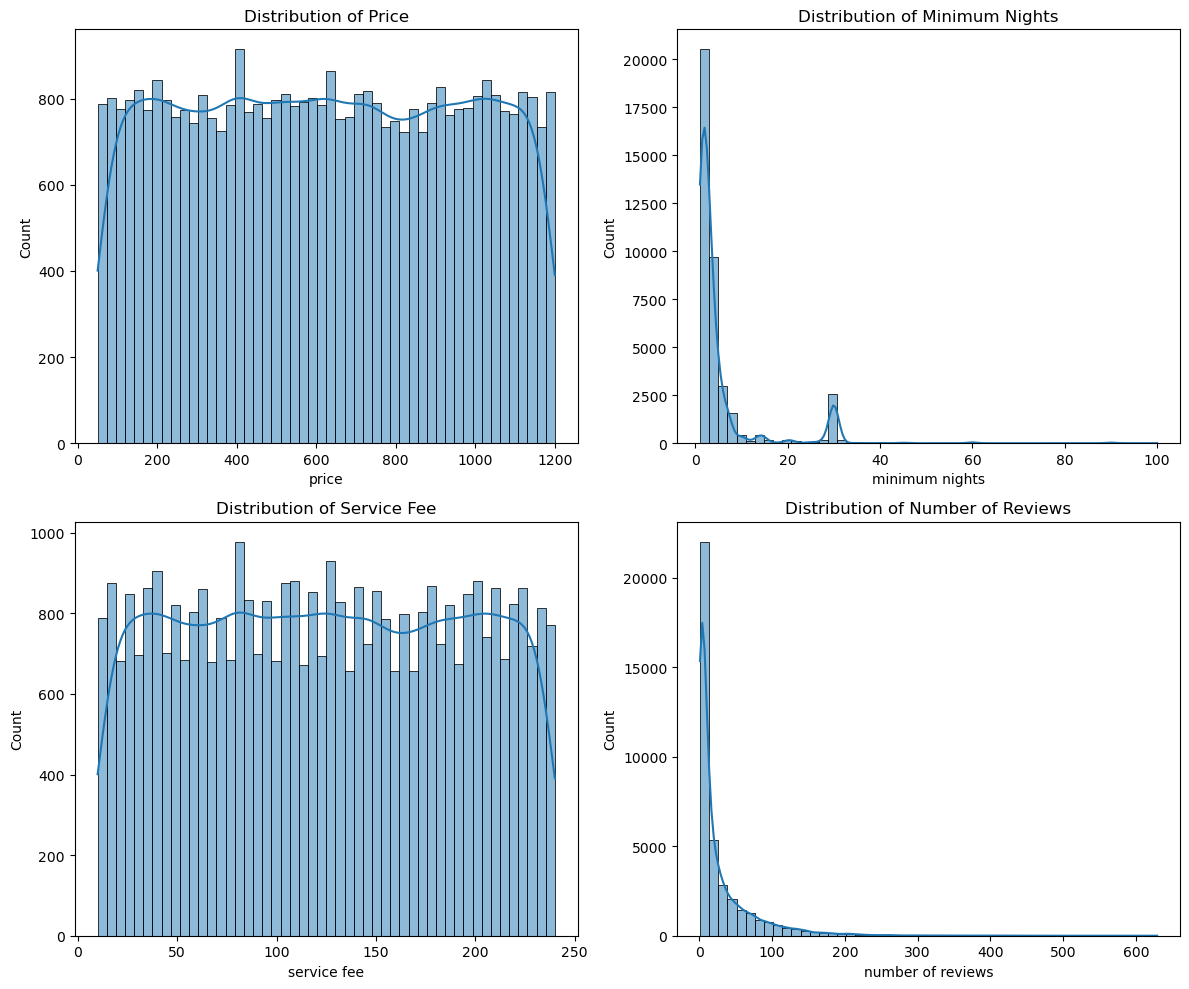

In [33]:
# distribution for price and minimum nights
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['price'], bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Price')
sns.histplot(df['minimum nights'], bins=50, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Minimum Nights')
sns.histplot(df['service fee'], bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of Service Fee')
sns.histplot(df['number of reviews'], bins=50, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution of Number of Reviews')
plt.tight_layout()
plt.show()

In [34]:
# Feature engeneering 
# Distance to Times Square - idk if this is useful but why not

times_sq_lat, times_sq_lon = 40.7580, -73.9855
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

df["dist_to_times_sq_km"] = haversine(df["lat"], df["long"], times_sq_lat, times_sq_lon)

In [35]:
# cwd = os.getcwd()
# if os.path.basename(cwd) == "Notebooks":
#     project_root = os.path.dirname(cwd)
# else:
#     project_root = cwd
# save_path = os.path.join(project_root, "data", "Airbnb_Processed_Data.csv")
# df.to_csv(save_path, index=False)